<a href="https://colab.research.google.com/github/fizafarooqq/CVise-AI-Based-Resume-Analyzer/blob/main/ds_project_ga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

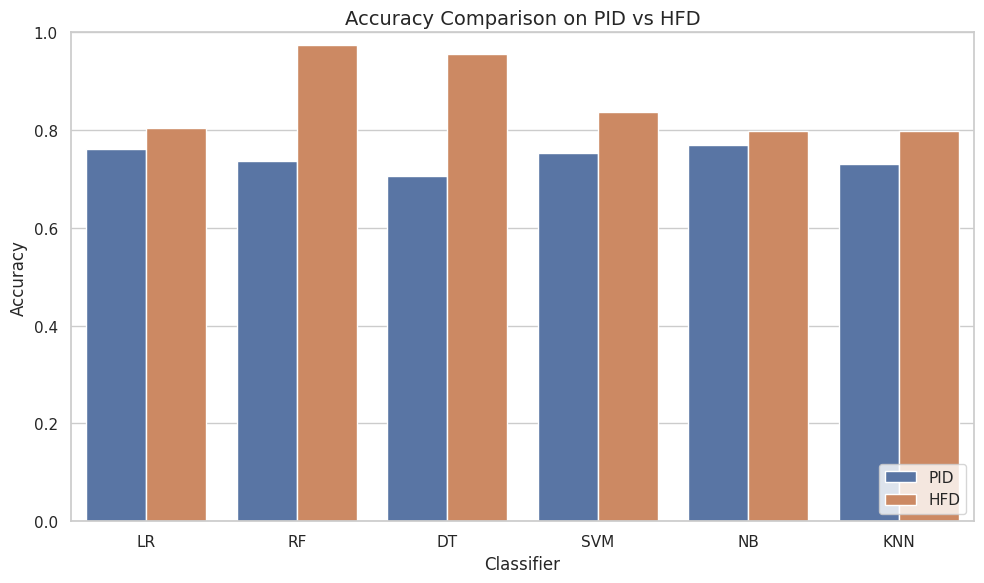

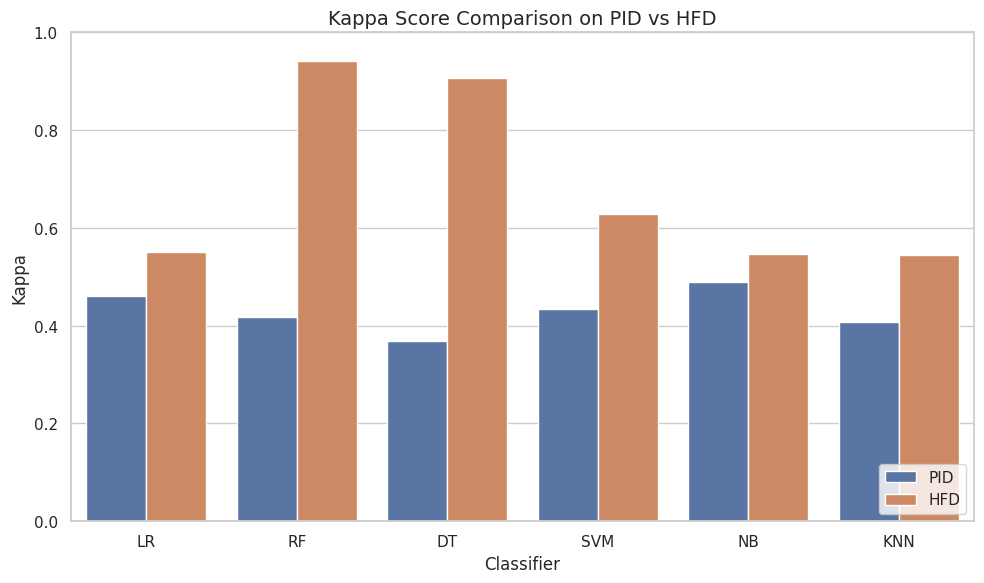

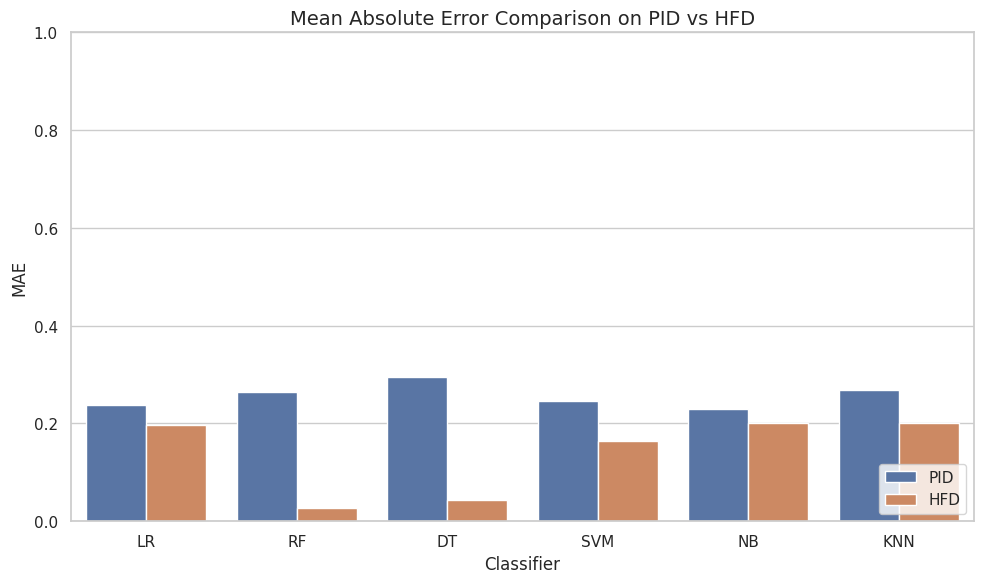


Selected Features - PID: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']

Selected Features - HFD: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Evaluation Metrics:
   Classifier  Accuracy     Kappa       MAE Dataset
0         LR  0.761905  0.459844  0.238095     PID
1         RF  0.735931  0.418472  0.264069     PID
2         DT  0.705628  0.368396  0.294372     PID
3        SVM  0.753247  0.433361  0.246753     PID
4         NB  0.770563  0.488746  0.229437     PID
5        KNN  0.731602  0.407202  0.268398     PID
0         LR  0.803333  0.551189  0.196667     HFD
1         RF  0.973333  0.941772  0.026667     HFD
2         DT  0.956667  0.906789  0.043333     HFD
3        SVM  0.836667  0.628098  0.163333     HFD
4         NB  0.798333  0.547438  0.201667     HFD
5        KNN  0.798333  0.545420  0.201667     HFD


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error

sns.set(style="whitegrid")

# Classifiers
classifiers = {
    "LR": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(),
    "DT": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "NB": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

# GA utility functions
def initialize_population(size, num_features):
    return np.random.randint(0, 2, size=(size, num_features))

def fitness(individual, X_train, X_test, y_train, y_test):
    selected = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected) == 0:
        return 0
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train[:, selected], y_train)
    preds = model.predict(X_test[:, selected])
    return accuracy_score(y_test, preds)

def selection(pop, scores):
    idx = np.argsort(scores)[-2:]
    return pop[idx[0]], pop[idx[1]]

def crossover(p1, p2):
    point = np.random.randint(1, len(p1) - 1)
    return np.concatenate([p1[:point], p2[point:]])

def mutate(child, rate):
    for i in range(len(child)):
        if np.random.rand() < rate:
            child[i] = 1 - child[i]
    return child

# GA runner
def run_ga_feature_selection(df, pop_size=20, generations=50, mutation_rate=0.1):
    X = df.drop(columns='Outcome')
    y = df['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    population = initialize_population(pop_size, X.shape[1])
    for _ in range(generations):
        scores = [fitness(ind, X_train_scaled, X_test_scaled, y_train, y_test) for ind in population]
        new_pop = []
        for _ in range(pop_size // 2):
            p1, p2 = selection(population, scores)
            child1, child2 = crossover(p1, p2), crossover(p2, p1)
            new_pop.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])
        population = np.array(new_pop)

    best_ind = population[np.argmax([fitness(ind, X_train_scaled, X_test_scaled, y_train, y_test) for ind in population])]
    selected_features = [i for i in range(len(best_ind)) if best_ind[i] == 1]
    selected_columns = X.columns[selected_features]

    # Evaluate
    results = []
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled[:, selected_features], y_train)
        preds = clf.predict(X_test_scaled[:, selected_features])
        acc = accuracy_score(y_test, preds)
        kappa = cohen_kappa_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        results.append((name, acc, kappa, mae))

    return selected_columns, pd.DataFrame(results, columns=["Classifier", "Accuracy", "Kappa", "MAE"])

# Load datasets
pid_df = pd.read_csv("diabetes.csv")
hfd_df = pd.read_csv("diabetes2.csv")

# Run GA
pid_features, pid_results = run_ga_feature_selection(pid_df)
hfd_features, hfd_results = run_ga_feature_selection(hfd_df)

# Add dataset label
pid_results["Dataset"] = "PID"
hfd_results["Dataset"] = "HFD"
all_results = pd.concat([pid_results, hfd_results])

# --- Visualization ---
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Classifier", y=metric, hue="Dataset")
    plt.title(title, fontsize=14)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Visualize Accuracy, Kappa, MAE
plot_metric(all_results, "Accuracy", "Accuracy Comparison on PID vs HFD")
plot_metric(all_results, "Kappa", "Kappa Score Comparison on PID vs HFD")
plot_metric(all_results, "MAE", "Mean Absolute Error Comparison on PID vs HFD")

# Final Output
print("\nSelected Features - PID:", list(pid_features))
print("\nSelected Features - HFD:", list(hfd_features))
print("\nEvaluation Metrics:\n", all_results)
